In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import ast

pd.set_option('display.max_columns', None)

In [2]:
def corr_(df, n = 0.85, x = 1):
    '''
    
    Input - df: dataframe
            n: lower limit of correlation
            x: upper limit of correlation
            
    Output - dataframe with correlated pairs and correlation values
    
    '''
    df_cc=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df_cc['pairs'] = list(zip(df_cc.level_0, df_cc.level_1))
    df_cc.set_index(['pairs'], inplace = True)
    df_cc.drop(columns=['level_1', 'level_0'], inplace = True)
    df_cc.columns = ['cc']
    df_cc.drop_duplicates(inplace=True)
    
    return df_cc[(df_cc['cc'] > n) & (df_cc['cc'] < x)]

def find_outlier(df, feature):
    '''
    Input - dataframe, column/feature with outliers
    
    Output - quartiles 
    '''
       
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower = q1-(iqr*1.5)
    upper = q3+(iqr*1.5)
    return iqr, lower, upper

def convert_game_clock(row):
    '''
    Input - game clock in min:sec
    
    Output - converted time in seconds left in quarter
    
    '''
    raw_game_clock = row['clock']
    quarter = int(row['quarter'])
    game_clock = raw_game_clock.split(':')
    minutes = game_clock[0]
    seconds = game_clock[1]
    seconds_left_in_quarter = int(seconds) + (int(minutes) * 60)
    
    if quarter == 1 or quarter == 3:
        return seconds_left_in_quarter + 900
    elif quarter == 2 or quarter == 4:
        return seconds_left_in_quarter
    
    
def make_table(data, groups, agg=['sum', 'count']):
    '''
    Input - dataframe, target features to aggregate
    
    Output - new dataframe with sum and count of grouped features
    '''
    data = data.groupby(groups).agg(agg)['complete']
    data['pct'] = data['sum']/data['count']
    return data


def yards_to_goal(row):
    '''
    Input - Series with dictionary of yardline info for both teams
    
    Output - Starting yardline location of play
    '''
    if row['start_location']['alias'] == row['team']:
        return 100 - row['start_location']['yardline']
    else:
        return row['start_location']['yardline']

In [3]:
df = pd.read_csv('./Data/all_dfs.csv', index_col=0)

In [4]:
df.shape

(13693, 36)

In [5]:
df.isna().sum().sort_values(ascending=False)

nullified            13691
result               13685
interception         13437
touchdown            13111
incompletion_type     9641
yards                 4052
complete               256
direction               11
pocket_time              2
firstdown                2
att_yards                1
pass_route               0
pocket_location          0
down                     0
players_rushed           0
qb_at_snap               0
season                   0
blitz_y                  0
run_pass_option          0
play_action              0
hash_mark                0
yards_to_first           0
name                     0
quarter                  0
clock                    0
end_location             0
team                     0
sequence                 0
batted_pass              0
on_target_throw          0
knockdown                0
hurry                    0
blitz_x                  0
goaltogo                 0
inside_20                0
start_location           0
dtype: int64

- nullified --> was play null --> drop
- result --> qb tackled after play --> drop
- interception --> change nan to 0
- touchdown --> change nan to 0
- incompletion type --> change to 'complete'
- yards --> change nan to 0 --> will most likely use att_yards for qb accuracy
- complete --> change nan to 0
- direction --> drop 11 nans
- firstdown and pocket_time --> drop 2 nans
- att_yards --> drop single missing


In [6]:
drop_cols = ['nullified', 'result']
make_zero = ['interception', 'touchdown', 'yards', 'complete']
drop_ind = df.loc[(df['direction'].isna()) |
                  (df['firstdown'].isna()) |
                  (df['att_yards'].isna())].index

df.drop(drop_cols, axis=1, inplace=True)
df.drop(drop_ind, axis=0, inplace=True)

for col in make_zero:
    df[col].fillna(value=0, inplace=True)
    
df['incompletion_type'].fillna(value='Complete', inplace=True)

In [7]:
df = df.sort_values('name').reset_index(drop=True)

In [8]:
qb_attempts = {}
for n in df['name']:
    k = n
    if k not in qb_attempts.keys():
        v = len(df.loc[df['name'] == k])
        qb_attempts[k] = v
    else:
        continue
        
qb_attempts = sorted(qb_attempts.items(), key=lambda item: item[1])

In [9]:
low_throw_count = []
for qb, passes in qb_attempts:
    if passes <= 10:
        low_throw_count.append(qb)

In [10]:
df = df.drop(index=df.loc[df['name'].isin(low_throw_count)].index)

In [11]:
df['start_location'] = df['start_location'].map(lambda x: ast.literal_eval(x))

In [12]:
df['yards_to_goal'] = df.apply(yards_to_goal, axis=1)
ytg = df.pop('yards_to_goal')
df.insert(22, 'yards_to_goal', ytg)

## First Look

- a model that always predicts a complete pass will be correct 70% of the time
- last year's longest pass play went for 92 yards
    - longest pass in air is 60 yards
- most incomplete passes are due to poorly thrown balls

In [13]:
df['incompletion_type'].value_counts(normalize=True)

Complete         0.705115
Poorly Thrown    0.154481
Pass Defended    0.093087
Dropped Pass     0.044885
Thrown Away      0.002432
Name: incompletion_type, dtype: float64

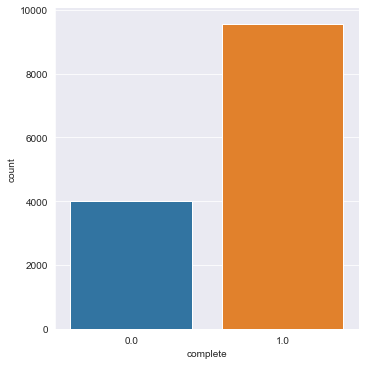

In [14]:
sns.catplot(x='complete', kind='count', data=df,
            orient='h', height=5, aspect=1);

### Matching `pass_route` with Conventional WR Route Tree Terms

<img src='./Images/route_tree.png' width="300" height="300">

### Route Tree Definitions
- Flat(Flat): short yardage; 3 yd break; to sideline
- Slant(Slant): short yardage; 3 yd break; slant towards middle of field
- Comeback(Comeback): medium yardage; 10 yd break; angle back towards sideline
- Curl(Curl): medium yardage; 10 yd break; angle back towards middle of field
- Out(Out): medium yardage; 10 yd break; towards sideline
- In/Dig(?): medium yardage; 10 yd break; towards middle of field
- Corner(?): med/long yardage; 10 yd break; angle forward towards sideline
- Post(Cross): med/long yardage; 10 yd break; angle forward towards middle of field
- Fade/Go(Go): long yardage; no break; run to endzone

In [15]:
df['direction'].value_counts()

short right     4827
short left      4546
short middle    2454
deep right       770
deep left        679
deep middle      292
Name: direction, dtype: int64

In [16]:
df.loc[df['direction'] == 'deep right', 'pass_route'].value_counts()

Go          536
Out         109
Comeback     46
Cross        32
Curl         28
Slant        19
Name: pass_route, dtype: int64

In [17]:
df.loc[df['pass_route'] == 'Out', 'att_yards'].describe()

count    2430.000000
mean        7.016461
std         5.094227
min        -5.000000
25%         4.000000
50%         5.000000
75%        10.000000
max        48.000000
Name: att_yards, dtype: float64

It seems like `pass_route` cannot be used to accurately convey where the quarterback was trying to throw. This could be due to multiple factors including:
1. Broken play
2. Scramble
3. Collapsed pocket

In order to determine the different areas that the quarterbacks targetted, we will be using `att_yards` to determine the distance of the throw as well as `direction` to determine the area of the field that was targetted.

In [18]:
df['att_yards'].describe()

count    13568.000000
mean         6.477889
std          9.630834
min        -11.000000
25%          1.000000
50%          4.000000
75%          9.000000
max         60.000000
Name: att_yards, dtype: float64

<AxesSubplot:>

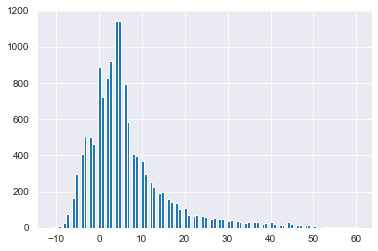

In [19]:
df['att_yards'].hist(bins='auto')

## Outliers

<AxesSubplot:>

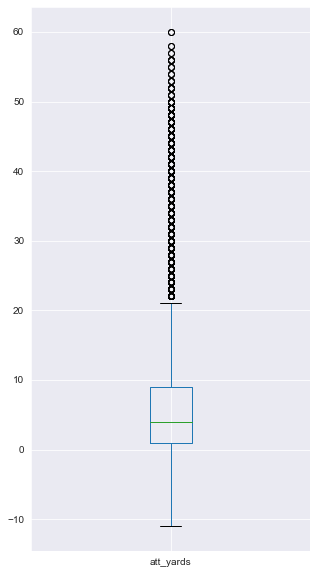

In [20]:
df.boxplot(column='att_yards', figsize=(5,10))

<AxesSubplot:>

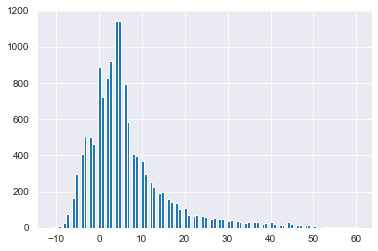

In [21]:
df['att_yards'].hist(bins='auto')

In [22]:
find_outlier(df, 'att_yards')

(8.0, -11.0, 21.0)

In [23]:
pct_outlier = len(df.loc[df['att_yards'] > 21]) / len(df)
print(f'Removing outliers results in {round(pct_outlier*100,2)}% data loss')

Removing outliers results in 7.46% data loss


In [24]:
df = df.loc[df['att_yards'] <= 21]

<AxesSubplot:>

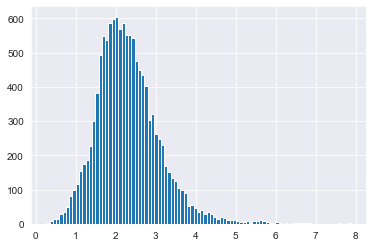

In [25]:
df['pocket_time'].hist(bins='auto')

In [26]:
find_outlier(df, 'pocket_time')

(0.9510000000000001, 0.3474999999999999, 4.1515)

In [27]:
pct_outlier = len(df.loc[df['pocket_time'] > 4.1515]) / len(df)
print(f'Removing outliers results in {round(pct_outlier*100,2)}% data loss')

Removing outliers results in 2.48% data loss


In [28]:
df = df.loc[df['pocket_time'] < 4.1515]

In [29]:
df['seconds_left_in_half'] = df.apply(convert_game_clock, axis=1)

In [30]:
repeating_cols = ['season', 'sequence']
df.drop(repeating_cols, axis=1, inplace=True)

In [31]:
drop_cols = ['team', 'start_location', 'end_location', 'clock']
df.drop(drop_cols, axis=1, inplace=True)

In [32]:
corr_(df, 0.8)

,cc
pairs,
"(complete, on_target_throw)",0.804859


In [33]:
df.drop('on_target_throw', axis=1, inplace=True)

In [34]:
for direc in df['direction'].unique():
    print(direc)
    print(f'Min: {min(df.loc[df["direction"] == direc, "att_yards"])}')
    print(f'Max: {max(df.loc[df["direction"] == direc, "att_yards"])}')
    print('\n')
    

short right
Min: -10.0
Max: 15.0


short middle
Min: -8.0
Max: 15.0


short left
Min: -11.0
Max: 19.0


deep middle
Min: 16.0
Max: 21.0


deep right
Min: 10.0
Max: 21.0


deep left
Min: 7.0
Max: 21.0




In [35]:
short = df.loc[df['direction'].str.contains('short')]
deep = df.loc[df['direction'].str.contains('deep')]

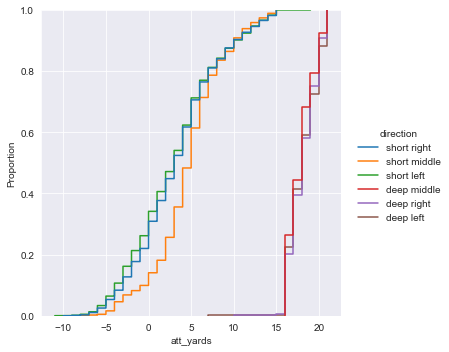

In [36]:
sns.displot(df, x='att_yards', hue='direction', kind='ecdf')

The cut-off for `short` and `deep` passes seem to be right around the 15 yard mark. We can categorize each pass as `behind`, `short`, `medium`, or `deep` by binning `att_yards` in discrete intervals.

In [37]:
att_dist = pd.cut(df['att_yards'],
                  bins=[-12, -1, 9, 19, 100],
                  labels=['behind', 'short', 'medium', 'deep'])
df = df.assign(att_dist=att_dist)

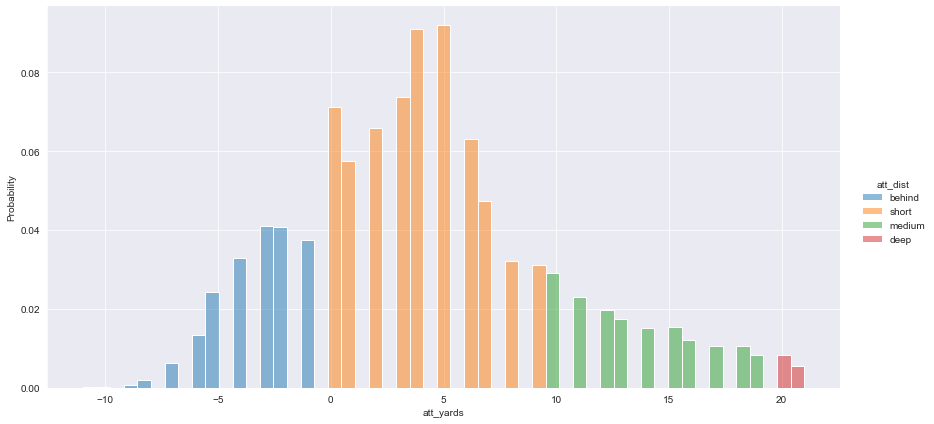

In [38]:
sns.displot(df, x='att_yards', hue='att_dist',
            height=6, aspect=2, stat='probability')

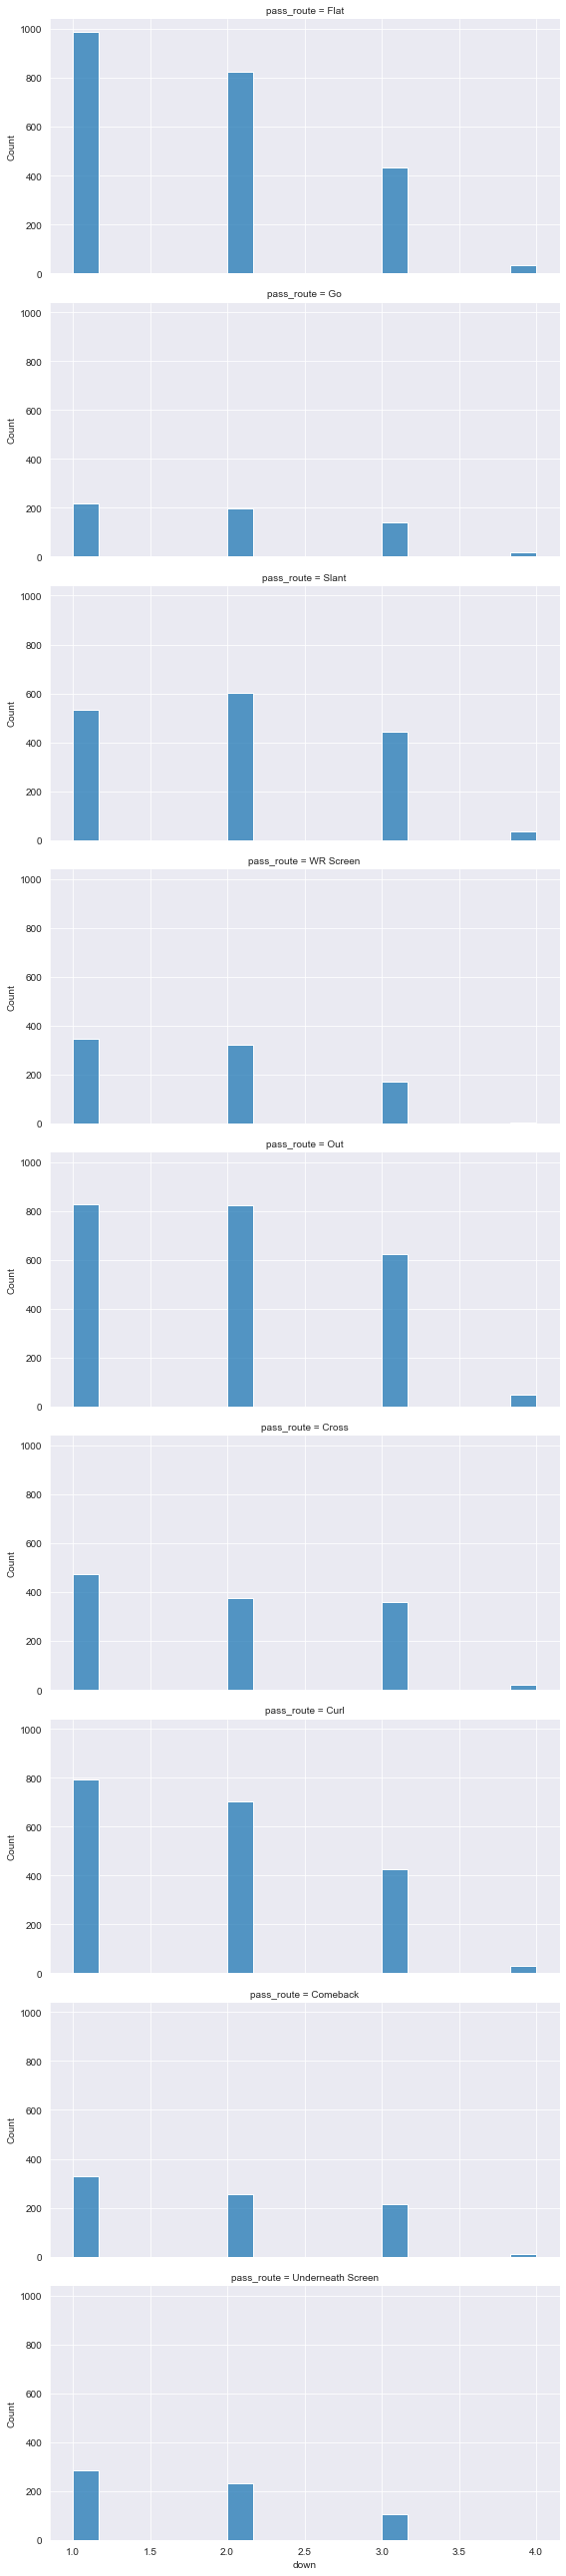

In [39]:
sns.displot(df, x='down', row='pass_route', height=4, aspect=2)

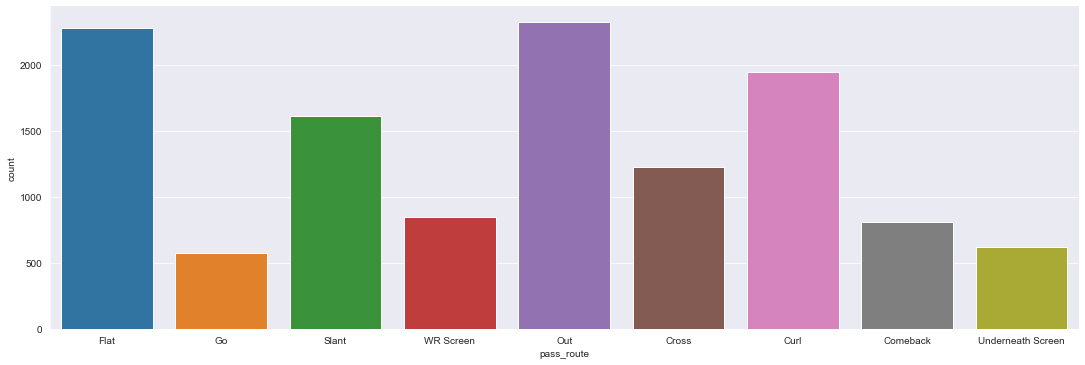

In [40]:
# plt.figure(figsize=(20,15));
sns.catplot(x='pass_route', kind='count', data=df, orient='h',
            height=5, aspect=3)

<AxesSubplot:xlabel='pass_route', ylabel='yards'>

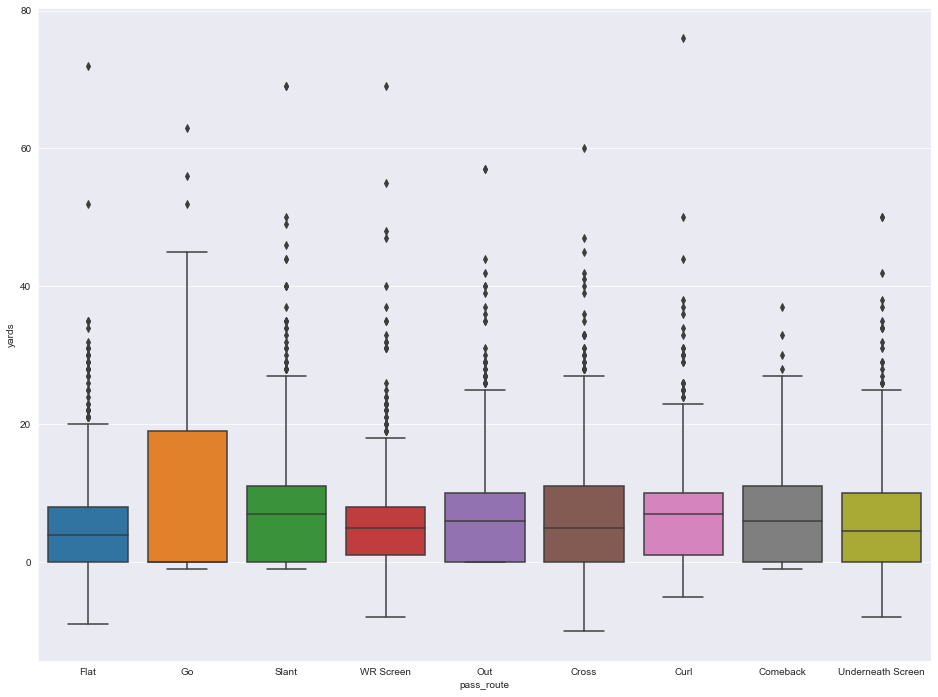

In [41]:
plt.figure(figsize=(16,12))
sns.boxplot(data=df, x='pass_route', y='yards')

# EDA
## Question 1

What is the relationship between the 9 different passing routes and the attempted yards for each route?

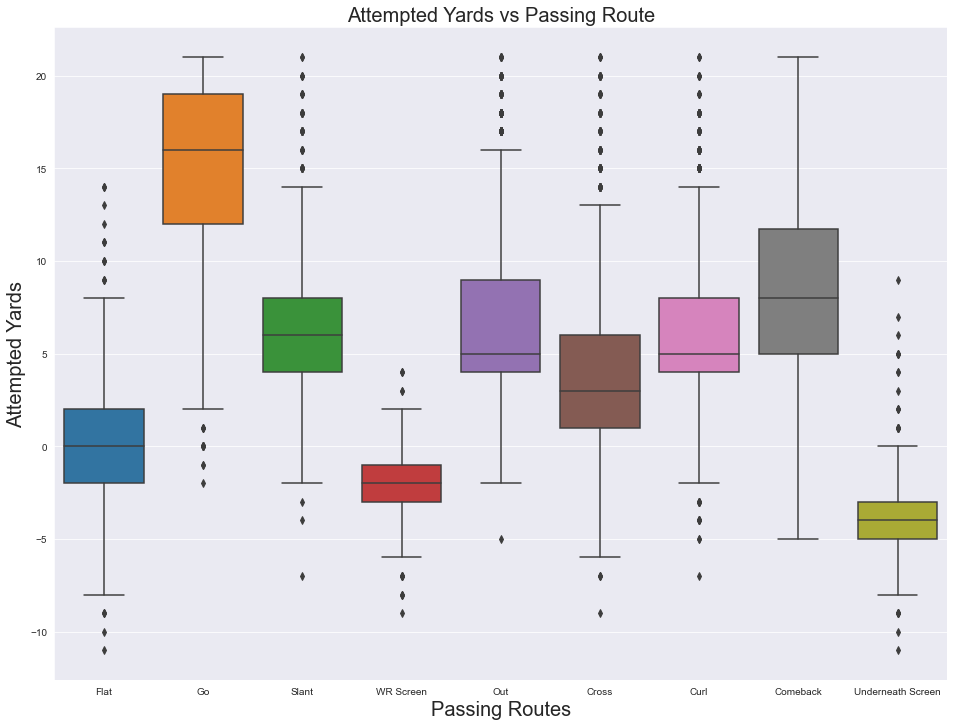

In [42]:
plt.figure(figsize=(16,12))

ax = sns.boxplot(data=df, x='pass_route', y='att_yards')

plt.title('Attempted Yards vs Passing Route', fontdict={'fontsize':20})
ax.set(xlabel='Passing Route', ylabel='Attempted Yards')

plt.xlabel('Passing Routes', fontdict={'fontsize':20})
plt.ylabel('Attempted Yards', fontdict={'fontsize':20})

plt.savefig('./Images/attyards_vs_passroute.png', format='png')
plt.show()


The attempted yards is distributed appropriately when taking into account the break distance and angle of each route. The `Go` route, a straight shot towards the endzone, has the highest mean and median of all the routes as well as the deepest attempted throw at 20+ yards. The screen plays, `WR Screen` and `Underneath Screen`, have the lowest averages for attempted yards per throw due to screen plays developing close to the line of scrimmage. A screen play wouldn't make much sense if the receiver is waiting to receive the ball 10+ yards down the field with no other teammates around to create a protective ___screen___.

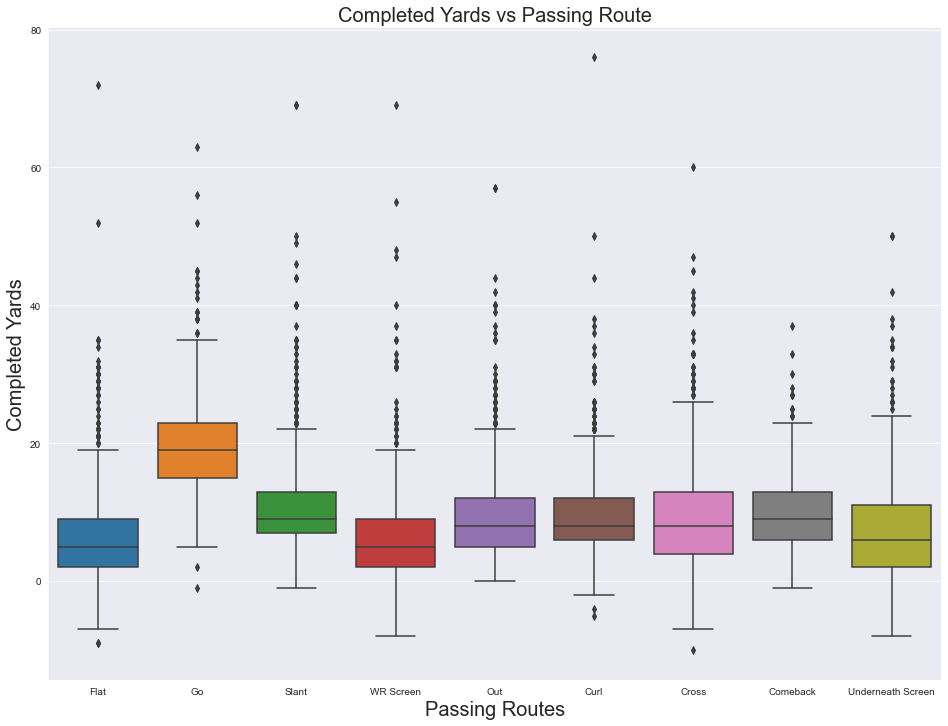

In [43]:
plt.figure(figsize=(16,12))

ax = sns.boxplot(data=df.loc[df['complete'] == 1],
                 x='pass_route', y='yards')

plt.title('Completed Yards vs Passing Route', fontdict={'fontsize':20})
ax.set(xlabel='Passing Route', ylabel='Completed Yards')

plt.xlabel('Passing Routes', fontdict={'fontsize':20})
plt.ylabel('Completed Yards', fontdict={'fontsize':20})

plt.savefig('./Images/completedyards_vs_passroute.png', format='png')
plt.show()


The completed yards by passing route shows an almost consistent median among all of the routes besides `Go`. While the other 8 plays have medians right around 5-10 yards (which is ideal for marching down the field slowly but surely), `Go` has a median value of around 20 yards.

In [44]:
qbs_by_att = df['name'].value_counts().sort_values(ascending=False).head(40)
passes_complete = df.groupby('name')['complete'].sum().sort_values(ascending=False)

qb_complete_pct = []
total_passes = []
for qb, item in qbs_by_att.iteritems():
    att = item
    pct = passes_complete[qb]/item
#     print(f'{qb.split(" ")[1]} completion percentage:\t {passes_complete[qb]/item}')
    qb_complete_pct.append((qb,att,pct))
    
qb_complete_pct = pd.DataFrame(qb_complete_pct, columns=['name', 'total_passes','completion_percentage'])
qb_complete_pct = qb_complete_pct.sort_values('completion_percentage', ascending=False)
qb_complete_pct['pct'] = qb_complete_pct['completion_percentage'].map(lambda x: x*100)

In [45]:
qb_complete_pct

,name,total_passes,completion_percentage,pct
11,Aaron Rodgers,356,0.817416,81.741573
12,Deshaun Watson,351,0.794872,79.487179
15,Teddy Bridgewater,320,0.793750,79.375000
30,Mitchell Trubisky,214,0.785047,78.504673
7,Philip Rivers,376,0.784574,78.457447
10,Kyler Murray,360,0.780556,78.055556
8,Russell Wilson,375,0.778667,77.866667
5,Josh Allen,401,0.770574,77.057357
27,Gardner Minshew II,227,0.766520,76.651982
2,Jared Goff,422,0.758294,75.829384


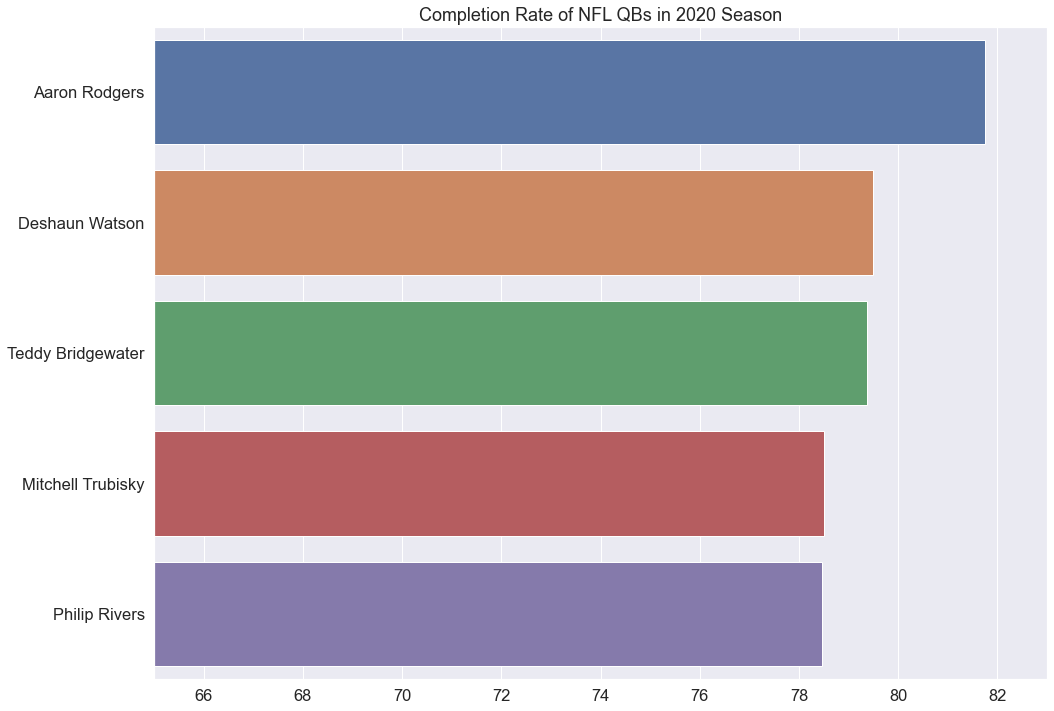

In [46]:
plt.figure(figsize=(16,12))
sns.set_theme(font_scale=1.5)
sns.barplot(data=qb_complete_pct[:5],
            x='pct', y='name', orient='h', palette='deep')
plt.xlim(65,83)
plt.title('Completion Rate of NFL QBs in 2020 Season')
plt.xlabel(None)
plt.ylabel(None)

plt.savefig('./Images/completionrate_2020.jpg')
plt.show()


## Question 2

How does the direction and distance of the pass affect the completion rate?

In [47]:
complete_by_direction = make_table(df, ['name', 'direction'])
complete_by_direction

sum  count       pct
name          direction                           
Aaron Rodgers deep left       2.0      5  0.400000
              deep middle     1.0      1  1.000000
              deep right      3.0     11  0.272727
              short left    113.0    139  0.812950
              short middle   34.0     42  0.809524
...                           ...    ...       ...
Tyrod Taylor  deep left       0.0      1  0.000000
              deep right      0.0      1  0.000000
              short left      6.0      7  0.857143
              short middle    2.0      3  0.666667
              short right     4.0      5  0.800000

[333 rows x 3 columns]

In [48]:
direction_complete_pct = complete_by_direction.unstack()['pct'].mean()
direction_complete_pct = direction_complete_pct.map(lambda x: x*100)

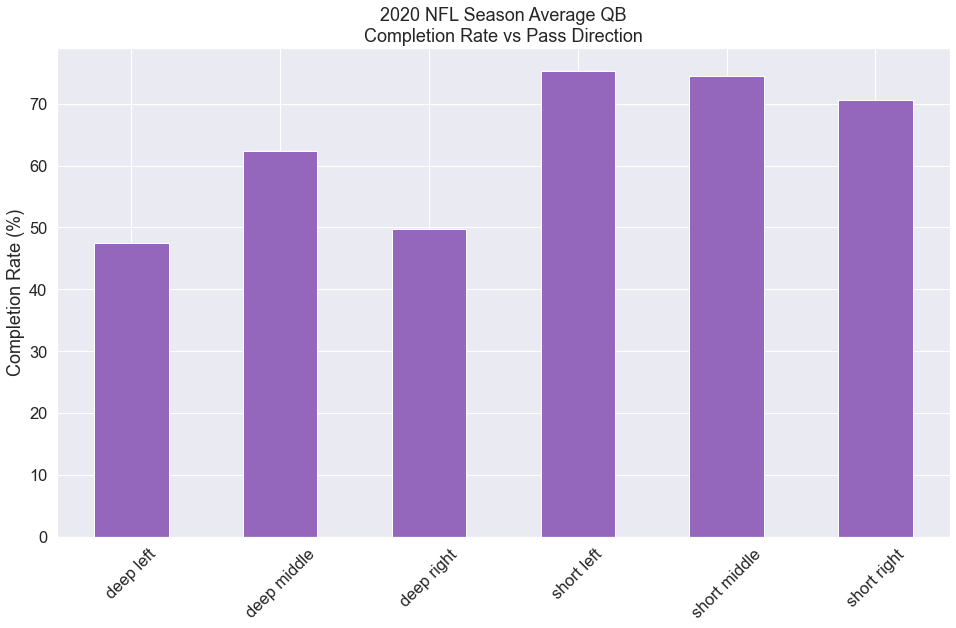

In [49]:
direction_complete_pct.plot(kind='bar', figsize=(16,9),
                            color='tab:purple', rot=45)
plt.xlabel(None)
plt.ylabel('Completion Rate (%)')
plt.title('2020 NFL Season Average QB\nCompletion Rate vs Pass Direction')

plt.savefig('./Images/completion_vs_passdirec.png', format='png')
plt.show()


The completion percentage of passes decreases as the distance increases from the line of scrimmage. This result is expected as the ball needs to travel a greater distance, requiring increased accuracy and precision by the quarterback.

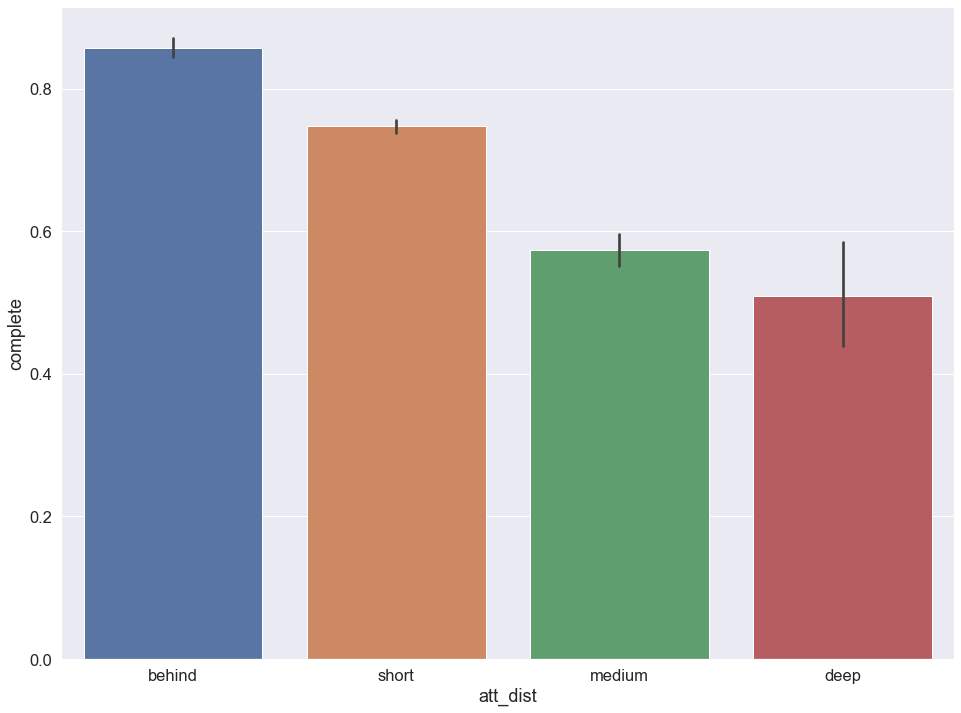

In [50]:
plt.figure(figsize=(16,12))
sns.barplot(data=df, x='att_dist', y='complete')

plt.show()

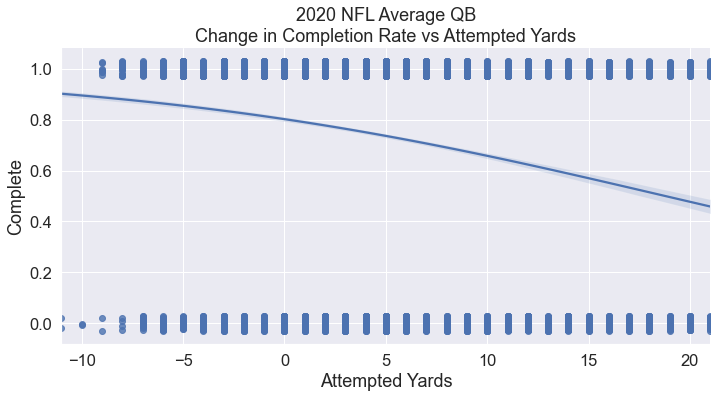

In [51]:
sns.lmplot(x='att_yards', y='complete', data=df,
          y_jitter=0.03, logistic=True, aspect=2)
plt.title('2020 NFL Average QB\nChange in Completion Rate vs Attempted Yards')
plt.xlabel('Attempted Yards')
plt.ylabel('Complete')

plt.savefig('./Images/avg_complete_vs_attyards.png', format='png')
plt.show()


The plot above illustrates the relationship between completion rate and the yards that the ball traveled in the air. As the attempted yards, `att_yards`, increases, the number of completed passes decreases.

## Question 3

How do NFL QB's perform in the pocket?

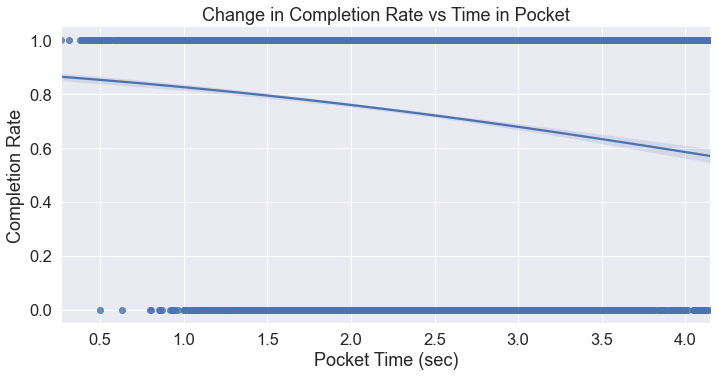

In [52]:
sns.lmplot(x='pocket_time', y='complete', data=df, logistic=True, aspect=2)
plt.xlabel('Pocket Time (sec)')
plt.ylabel('Completion Rate')
plt.title('Change in Completion Rate vs Time in Pocket')
plt.savefig('./Images/complete_vs_pocket_time.png', format='png')
plt.show()


Completion rate decreases as the time the quarterback spends in the pocket increases. Although the quarterback has more time to go through the progression of the play, get their feet set, and pick their target, the play still has many other factors that can lead to a dropped or incomplete pass.

In [53]:
df['pocket_location'].value_counts()

Middle            10833
Boot Right          382
Rollout Right       361
Scramble Right      320
Boot Left           157
Scramble Left       119
Rollout Left         73
Name: pocket_location, dtype: int64

In [54]:
pocket_qb = df.loc[df['pocket_location'] == 'Middle']
pocket_qb

,name,complete,yards,att_yards,firstdown,inside_20,goaltogo,blitz_x,hurry,knockdown,pocket_time,batted_pass,incompletion_type,interception,direction,quarter,yards_to_goal,down,yards_to_first,hash_mark,play_action,run_pass_option,blitz_y,qb_at_snap,players_rushed,pocket_location,pass_route,touchdown,seconds_left_in_half,att_dist
0,Aaron Rodgers,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.134,0.0,Complete,0.0,short right,2.0,31,1,10,Right Hash,False,False,False,Shotgun,4.0,Middle,Flat,0.0,120,short
1,Aaron Rodgers,1.0,14.0,13.0,1.0,1.0,0.0,0.0,0.0,0.0,1.820,0.0,Complete,0.0,short right,2.0,14,2,9,Left Hash,False,False,False,Shotgun,4.0,Middle,Go,1.0,858,medium
2,Aaron Rodgers,1.0,12.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,1.855,0.0,Complete,0.0,short middle,1.0,27,1,10,Left Hash,False,False,True,Shotgun,6.0,Middle,Slant,0.0,913,short
3,Aaron Rodgers,1.0,5.0,-4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.191,0.0,Complete,0.0,short left,1.0,32,2,5,Right Hash,True,True,False,Shotgun,4.0,Middle,WR Screen,0.0,953,behind
4,Aaron Rodgers,1.0,3.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.697,0.0,Complete,0.0,short right,1.0,56,2,7,Left Hash,False,False,False,Shotgun,4.0,Middle,Flat,0.0,1203,behind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13664,Tyrod Taylor,1.0,8.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.701,0.0,Complete,0.0,short left,4.0,22,2,8,Left Hash,True,True,False,Under Center,4.0,Middle,Flat,0.0,695,short
13665,Tyrod Taylor,0.0,0.0,6.0,0.0,1.0,1.0,0.0,0.0,0.0,2.387,0.0,Poorly Thrown,0.0,short left,2.0,6,3,6,Left Hash,False,False,False,Shotgun,4.0,Middle,Slant,0.0,438,short
13669,Tyrod Taylor,1.0,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.862,0.0,Complete,0.0,short middle,4.0,77,2,11,Right Hash,False,False,False,Shotgun,4.0,Middle,Curl,0.0,274,short
13670,Tyrod Taylor,1.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.682,0.0,Complete,0.0,short right,1.0,46,3,9,Middle,False,False,False,Shotgun,3.0,Middle,Slant,0.0,909,short


In [55]:
best_pocket_qb = make_table(pocket_qb, ['name'])
best_pocket_qb = best_pocket_qb.loc[best_pocket_qb['count'] > 100]
best_pocket_qb = best_pocket_qb.unstack()['pct']
best_pocket_qb = best_pocket_qb.map(lambda x: x*100)
best_pocket_qb.sort_values(ascending=False, inplace=True)

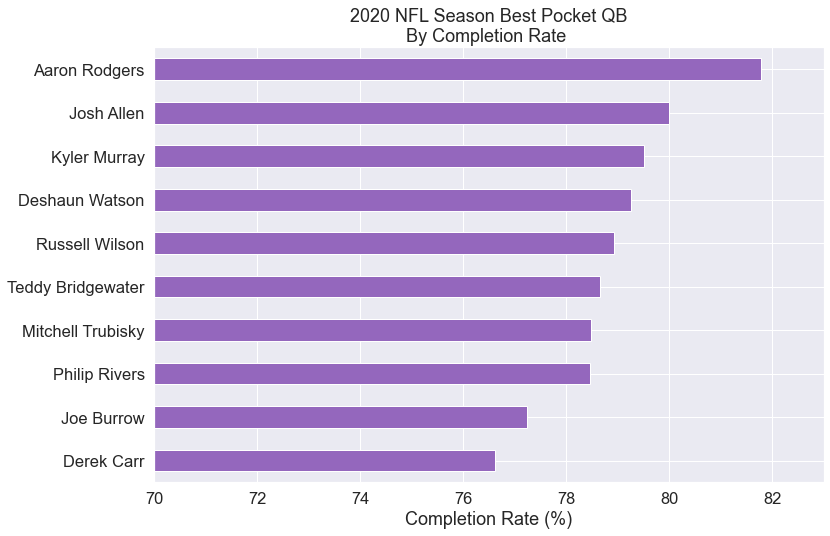

In [56]:
##### plt.figure(figsize=(16,12))
plt.figure(figsize=(12,8))

best_pocket_qb[9::-1].plot(y='pct', kind='barh', color='tab:purple',
                         xlim=(70,83))
plt.xlabel('Completion Rate (%)')
plt.ylabel(None)
plt.title('2020 NFL Season Best Pocket QB\nBy Completion Rate ')
plt.savefig('./Images/bestPocketQB_bycompletion.png', format='png')
plt.show()


In [57]:
best_pocket_qb

name
Aaron Rodgers         81.789137
Josh Allen            80.000000
Kyler Murray          79.503106
Deshaun Watson        79.264214
Russell Wilson        78.929766
Teddy Bridgewater     78.647687
Mitchell Trubisky     78.488372
Philip Rivers         78.453039
Joe Burrow            77.235772
Derek Carr            76.615385
Jared Goff            76.271186
Gardner Minshew II    76.213592
Alex Smith            76.136364
Patrick Mahomes II    76.100629
Kirk Cousins          75.874126
Tom Brady             75.572519
Drew Brees            75.000000
Nick Foles            74.626866
Baker Mayfield        74.242424
Matt Ryan             74.043716
Mike Glennon          73.786408
Sam Darnold           73.762376
Justin Herbert        73.107050
Lamar Jackson         72.946860
Dak Prescott          72.916667
Ryan Fitzpatrick      72.395833
Matthew Stafford      72.327044
Cam Newton            71.875000
Andy Dalton           71.698113
Nick Mullens          71.356784
Tua Tagovailoa        71.345029
Dwa

Aaron Rodgers, the 2020 NFL Season MVP, had the highest completion rate when standing in the middle of the pocket compared to the rest of the league. He is almost 2% higher than the runner-up Josh Allen who is followed very closely by 6 others within the same gap (+/- 1.8%).

# Recommendations

In [208]:
df.groupby(['down', 'pass_route']).mean()

complete      yards  att_yards  firstdown  inside_20  \
down pass_route                                                                
1    Comeback           0.695122   7.134146   8.466463   0.350610   0.051829   
     Cross              0.773305   7.279661   3.983051   0.343220   0.122881   
     Curl               0.776515   7.196970   5.929293   0.287879   0.058081   
     Flat               0.826263   5.267677  -0.481818   0.210101   0.117172   
     Go                 0.511416  10.328767  14.392694   0.470320   0.232877   
     Out                0.722892   6.868675   6.789157   0.280723   0.110843   
     Slant              0.671053   7.620301   6.063910   0.360902   0.156015   
     Underneath Screen  0.788732   6.116197  -3.672535   0.264085   0.063380   
     WR Screen          0.907514   5.598266  -2.141618   0.173410   0.089595   
2    Comeback           0.674510   6.552941   8.168627   0.423529   0.054902   
     Cross              0.750663   7.047745   4.318302   0.432361   0.164456   
     Curl               0.779202   6.931624   5.603989   0.387464   0.078348   
     Flat               0.810450   4.699878  -0.362090   0.302552   0.151883   
     Go                 0.472081   9.522843  14.568528   0.436548   0.233503   
     Out                0.734793   6.759124   6.590024   0.401460   0.098540   
     Slant              0.704319   7.232558   5.941860   0.451827   0.156146   
     Underneath Screen  0.848485   5.822511  -3.861472   0.277056   0.125541   
     WR Screen          0.910217   5.030960  -2.303406   0.244582   0.089783   
3    Comeback           0.563380   5.521127   8.478873   0.403756   0.084507   
     Cross              0.698324   6.634078   4.156425   0.405028   0.120112   
     Curl               0.696471   6.818824   7.002353   0.487059   0.112941   
     Flat               0.770833   4.935185   0.233796   0.363426   0.159722   
     Go                 0.366197   7.169014  15.302817   0.359155   0.281690   
     Out                0.660256   6.352564   6.794872   0.511218   0.136218   
     Slant              0.638202   7.020225   5.842697   0.492135   0.177528   
     Underneath Screen  0.849057   6.471698  -3.858491   0.198113   0.094340   
     WR Screen          0.901163   7.244186  -1.808140   0.279070   0.081395   
4    Comeback           0.600000   5.900000   9.500000   0.600000   0.000000   
     Cross              0.809524   3.619048   3.952381   0.523810   0.523810   
     Curl               0.620690   7.241379   8.310345   0.586207   0.068966   
     Flat               0.735294   6.088235   2.294118   0.647059   0.323529   
     Go                 0.368421   9.526316  14.421053   0.315789   0.052632   
     Out                0.571429   5.632653   6.306122   0.551020   0.224490   
     Slant              0.777778   6.888889   5.055556   0.750000   0.361111   
     Underneath Screen  1.000000   3.000000  -3.000000   1.000000   0.000000   
     WR Screen          0.750000   8.250000  -2.000000   0.500000   0.000000   

                        goaltogo   blitz_x     hurry  knockdown  pocket_time  \
down pass_route                                                                
1    Comeback           0.036585  0.237805  0.094512   0.097561     2.556433   
     Cross              0.065678  0.258475  0.080508   0.082627     2.347337   
     Curl               0.021465  0.198232  0.039141   0.053030     2.323077   
     Flat               0.060606  0.286869  0.078788   0.055556     2.369552   
     Go                 0.041096  0.310502  0.063927   0.091324     2.353183   
     Out                0.060241  0.268675  0.083133   0.072289     2.371316   
     Slant              0.088346  0.315789  0.041353   0.058271     2.085094   
     Underneath Screen  0.024648  0.267606  0.109155   0.052817     2.285673   
     WR Screen          0.031792  0.297688  0.017341   0.023121     1.398006   
2    Comeback           0.023529  0.286275  0.101961   0.101961     2.530561   
     Cross             

In [206]:
df.groupby('pass_route').mean()

,complete,yards,att_yards,firstdown,inside_20,goaltogo,blitz_x,hurry,knockdown,pocket_time,batted_pass,interception,quarter,yards_to_goal,down,yards_to_first,play_action,run_pass_option,blitz_y,players_rushed,touchdown,seconds_left_in_half
pass_route,,,,,,,,,,,,,,,,,,,,,,
Comeback,0.652605,6.508685,8.388337,0.390819,0.060794,0.029777,0.285360,0.100496,0.105459,2.549163,0.013648,0.019851,2.543424,55.347395,1.882134,8.787841,0.213400,0.078164,0.285360,4.264268,0.013648,780.789082
Cross,0.745114,6.957655,4.135993,0.391694,0.141694,0.066775,0.329805,0.090391,0.103420,2.400556,0.011401,0.015472,2.517915,49.642508,1.941368,8.351792,0.267101,0.078990,0.329805,4.324104,0.052932,872.812704
Curl,0.757700,7.019507,6.081622,0.371663,0.077515,0.025667,0.227413,0.044661,0.073409,2.307188,0.023101,0.014374,2.607803,55.761807,1.841376,9.249487,0.114990,0.036448,0.227413,4.194559,0.019507,765.302875
Flat,0.808688,5.011847,-0.261518,0.279070,0.140851,0.061869,0.319438,0.084686,0.072400,2.299831,0.015358,0.004827,2.477841,50.751207,1.784993,8.559895,0.335235,0.084686,0.319438,4.286968,0.040807,853.577885
Go,0.457539,9.249567,14.677643,0.426343,0.239168,0.050260,0.318891,0.058925,0.098787,2.320104,0.005199,0.034662,2.677643,44.433276,1.932409,8.809359,0.145581,0.053726,0.318891,4.322357,0.110919,763.142114
Out,0.707097,6.665376,6.710108,0.390968,0.115699,0.052903,0.312688,0.073978,0.079570,2.348452,0.009462,0.016344,2.501505,52.635699,1.953548,8.436559,0.177204,0.047742,0.312688,4.326022,0.034409,805.332473
Slant,0.676780,7.294118,5.934985,0.439628,0.166563,0.093498,0.353560,0.048297,0.069350,2.097105,0.024768,0.027245,2.576471,49.600619,1.990712,8.118266,0.179567,0.079257,0.353560,4.400619,0.052012,804.654489
Underneath Screen,0.821543,6.062701,-3.773312,0.258842,0.091640,0.033762,0.270096,0.102894,0.065916,2.207212,0.024116,0.011254,2.454984,52.850482,1.717042,10.282958,0.331190,0.041801,0.270096,4.202572,0.019293,849.014469
WR Screen,0.906509,5.728994,-2.134911,0.223669,0.087574,0.033136,0.285207,0.016568,0.016568,1.359846,0.011834,0.002367,2.437870,53.439053,1.803550,9.983432,0.261538,0.131361,0.285207,4.186982,0.016568,869.345562


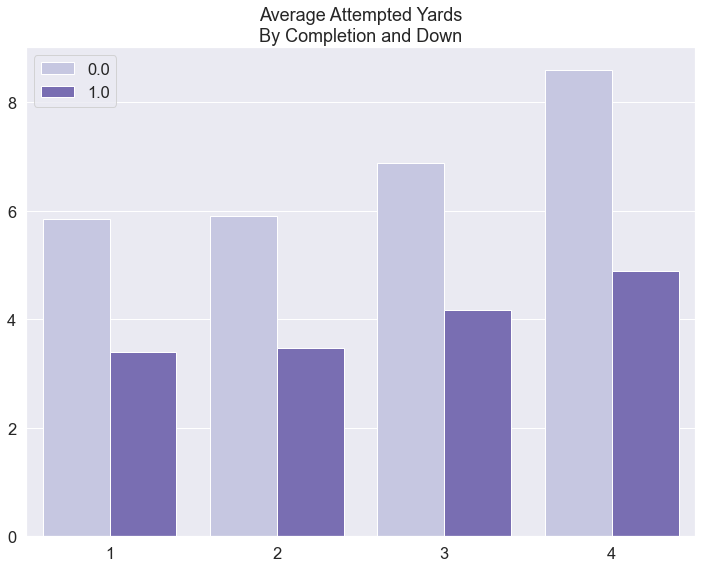

In [192]:
plt.figure(figsize=(12,9))

sns.barplot(x='down', y='att_yards', hue='complete', data=df,
           palette='Purples', ci=0, saturation=1)
plt.title('Average Attempted Yards\nBy Completion and Down')
plt.xticks(ticks=[0,1,2,3], labels=[1,2,3,4])
plt.xlabel(None)
plt.ylabel(None)
plt.legend(loc='best')
# plt.legend(labels=['Incomplete', 'Complete'], labelcolor='linecolor')
plt.show()

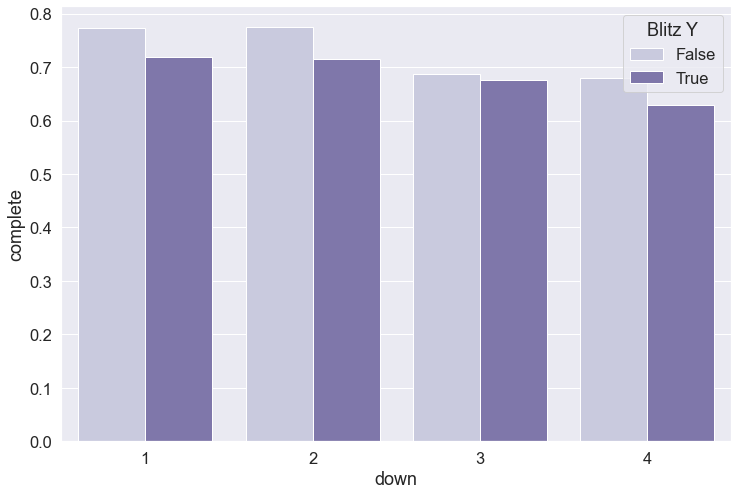

In [248]:
plt.figure(figsize=(12,8))

sns.barplot(x='down', y='complete', hue='blitz_y', data=df,
            saturation=.75, palette='Purples', ci=0)
plt.legend(title='Blitz Y')
plt.show()

In [257]:
df['blitz_y'] = df['blitz_y'].map(lambda x: 1 if x is True else 0)

In [263]:
df.loc[((df['blitz_x'] == 1 )|( df['blitz_y'] == 1)), 'blitz'] = 1

In [266]:
df['blitz'].fillna(0, inplace=True)

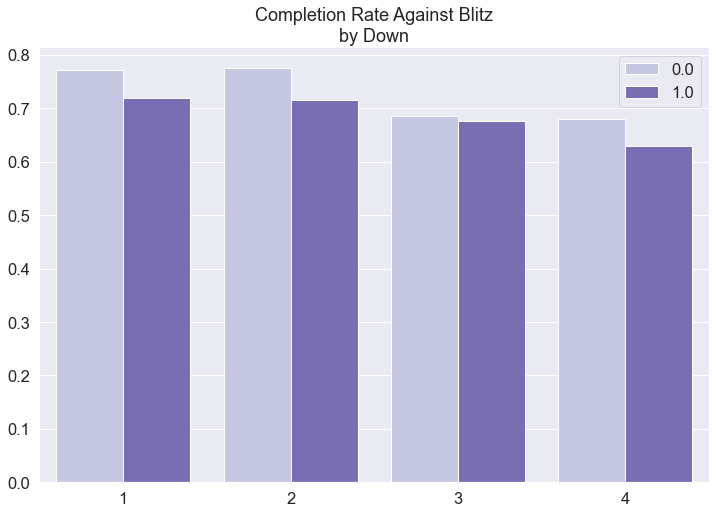

In [281]:
plt.figure(figsize=(12,8))

sns.barplot(x='down', y='complete', hue='blitz', data=df,
            saturation=1, palette='Purples', ci=0)
plt.title('Completion Rate Against Blitz\nby Down')
plt.legend(loc='best')
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [287]:
rz = df.loc[df['inside_20'] == 1]
rz

,name,complete,yards,att_yards,firstdown,inside_20,goaltogo,blitz_x,hurry,knockdown,pocket_time,batted_pass,incompletion_type,interception,direction,quarter,yards_to_goal,down,yards_to_first,hash_mark,play_action,run_pass_option,blitz_y,qb_at_snap,players_rushed,pocket_location,pass_route,touchdown,seconds_left_in_half,att_dist,blitz
1,Aaron Rodgers,1.0,14.0,13.0,1.0,1.0,0.0,0.0,0.0,0.0,1.820,0.0,Complete,0.0,short right,2.0,14,2,9,Left Hash,False,False,0,Shotgun,4.0,Middle,Go,1.0,858,medium,0.0
11,Aaron Rodgers,1.0,6.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,1.771,0.0,Complete,0.0,short left,1.0,6,2,6,Left Hash,False,False,0,Shotgun,4.0,Middle,Flat,1.0,1505,short,0.0
14,Aaron Rodgers,1.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,2.061,0.0,Complete,0.0,short right,1.0,3,3,3,Left Hash,False,False,1,Shotgun,5.0,Rollout Right,Flat,0.0,1146,short,1.0
26,Aaron Rodgers,1.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,3.353,0.0,Complete,0.0,short left,4.0,4,1,4,Left Hash,True,False,0,Under Center,4.0,Middle,Cross,1.0,727,short,0.0
29,Aaron Rodgers,1.0,5.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.030,0.0,Complete,0.0,short right,3.0,15,3,4,Left Hash,False,False,0,Shotgun,4.0,Middle,Flat,0.0,1362,short,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13603,Tua Tagovailoa,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.100,0.0,Pass Defended,0.0,short middle,4.0,1,3,1,Middle,False,False,0,Shotgun,4.0,Middle,Cross,0.0,808,short,0.0
13617,Tua Tagovailoa,0.0,0.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,1.621,0.0,Pass Defended,0.0,short left,3.0,5,1,5,Left Hash,False,False,0,Under Center,4.0,Middle,Go,0.0,1605,short,0.0
13638,Tua Tagovailoa,1.0,10.0,-2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.973,0.0,Complete,0.0,short middle,3.0,10,2,8,Left Hash,False,False,1,Pistol,5.0,Middle,Underneath Screen,1.0,1538,behind,1.0
13665,Tyrod Taylor,0.0,0.0,6.0,0.0,1.0,1.0,0.0,0.0,0.0,2.387,0.0,Poorly Thrown,0.0,short left,2.0,6,3,6,Left Hash,False,False,0,Shotgun,4.0,Middle,Slant,0.0,438,short,0.0


In [300]:
gl = df.loc[df['goaltogo'] == 1]
gl

,name,complete,yards,att_yards,firstdown,inside_20,goaltogo,blitz_x,hurry,knockdown,pocket_time,batted_pass,incompletion_type,interception,direction,quarter,yards_to_goal,down,yards_to_first,hash_mark,play_action,run_pass_option,blitz_y,qb_at_snap,players_rushed,pocket_location,pass_route,touchdown,seconds_left_in_half,att_dist,blitz
11,Aaron Rodgers,1.0,6.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,1.771,0.0,Complete,0.0,short left,1.0,6,2,6,Left Hash,False,False,0,Shotgun,4.0,Middle,Flat,1.0,1505,short,0.0
14,Aaron Rodgers,1.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,2.061,0.0,Complete,0.0,short right,1.0,3,3,3,Left Hash,False,False,1,Shotgun,5.0,Rollout Right,Flat,0.0,1146,short,1.0
26,Aaron Rodgers,1.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,3.353,0.0,Complete,0.0,short left,4.0,4,1,4,Left Hash,True,False,0,Under Center,4.0,Middle,Cross,1.0,727,short,0.0
45,Aaron Rodgers,1.0,9.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.901,0.0,Complete,0.0,short left,3.0,9,1,9,Left Hash,False,False,0,Shotgun,4.0,Middle,WR Screen,1.0,1365,short,0.0
51,Aaron Rodgers,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.127,0.0,Pass Defended,0.0,short middle,2.0,1,3,1,Right Hash,False,False,1,Under Center,3.0,Middle,Slant,0.0,516,short,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13602,Tua Tagovailoa,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.131,0.0,Poorly Thrown,0.0,short left,4.0,2,1,2,Middle,False,False,1,Under Center,7.0,Middle,Go,0.0,856,short,1.0
13603,Tua Tagovailoa,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.100,0.0,Pass Defended,0.0,short middle,4.0,1,3,1,Middle,False,False,0,Shotgun,4.0,Middle,Cross,0.0,808,short,0.0
13617,Tua Tagovailoa,0.0,0.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,1.621,0.0,Pass Defended,0.0,short left,3.0,5,1,5,Left Hash,False,False,0,Under Center,4.0,Middle,Go,0.0,1605,short,0.0
13665,Tyrod Taylor,0.0,0.0,6.0,0.0,1.0,1.0,0.0,0.0,0.0,2.387,0.0,Poorly Thrown,0.0,short left,2.0,6,3,6,Left Hash,False,False,0,Shotgun,4.0,Middle,Slant,0.0,438,short,0.0


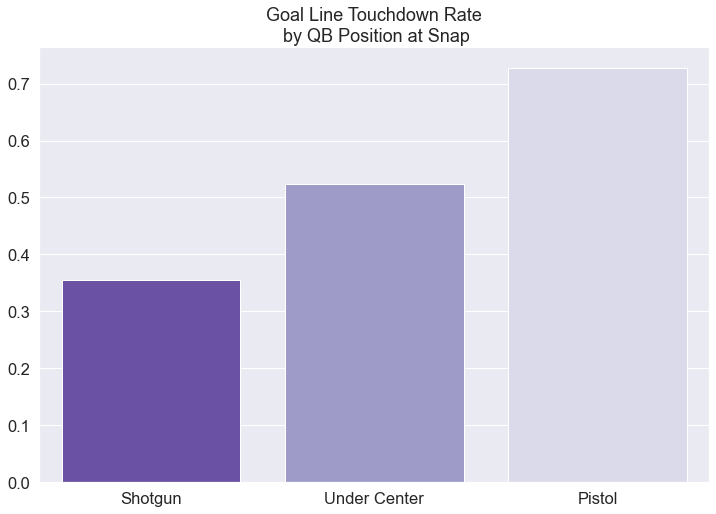

In [304]:
plt.figure(figsize=(12,8))

sns.barplot(x='qb_at_snap', y='touchdown', data=gl,
            saturation=1, palette='Purples_r', ci=0)
plt.title('Goal Line Touchdown Rate\n by QB Position at Snap')
# plt.legend(loc='best')
plt.xlabel(None)

plt.ylabel(None)
plt.show()